# ABIN Assignment 1 [Akshat Kumar, 2023060]

***Monte Carlo Study of Sequence Divergence Effects on Alignment and Motif Recovery***

in this project i designed and ran a simulation study to investigate how increasing sequence divergence affects:
1. distance measures (Hamming and edit distance)
2. global vs local alignment (needleman–wunsch and Smith–waterman)
3. motif recovery using a simple position weight matrix (PWM) approach

# Dataset Generation(Synthetic)

Step 1: need to create a random DNA sequence to serve as my starting point; and embed a 8bp motif at a random position within that sequence.


In [20]:
import random

# first im defining the bases and specifying all parameters.
dna_bases = 'ATGC'
sequence_length = 155
motif_length = 8
# generating the motif first
motif = "".join(random.choices(dna_bases, k=motif_length)) #using random
# now generating the full length random sequence
full_sequence = "".join(random.choices(dna_bases, k=sequence_length))
# im choosing a random start position for the motif to be placed, ensures the motif will fit entirely within the sequence
start_index = random.randint(0, sequence_length - motif_length)
# lastly i will overwrite the part of the sequence with the actual motif
# we build the new sequence from three pieces:
# a) the part before the motif
# b) the motif itself
# c) the part after the motif
original_sequence = full_sequence[:start_index] + motif + full_sequence[start_index + motif_length:]

print(f"original motif: {motif}")
print(f"sequence (of length {len(original_sequence)}):")
print(original_sequence)


original motif: GGTGAGCA
sequence (of length 155):
TGAAATATTGGTGCCGCCCCGCCCACGACTTTGCCTAGAGACCATGGCTAGAGAAGTACGCCCGTTACACTCCAGGTTCGAGTATACCGCTGAAGGATAATTAATACAGAGTCCGGGTGAGCACGTTCGGATAGCAAAATCACGCGCTCGAGGTG


Step 2: the mutation function, creating mutated copies at multiple divergence levels; this function will introduce random errors into a sequence (substitutions, insertions, deletions).

In [21]:
import random
# function that creates a single mutated copy
def mutate_sequence(sequence, divergence_level, include_indels=True):
    #introduces mutations into a sequence. can include indels or only substitutions.
    mutated_list = list(sequence)
    i = 0
    while i < len(mutated_list):
        if random.random() < divergence_level:
            if not include_indels:
                mutation_type = 'substitution'
            else:
                mutation_type = random.choices(
                    ['substitution', 'insertion', 'deletion'],
                    weights=[80, 10, 10]
                )[0]
            if mutation_type == 'substitution':
                current_base = mutated_list[i]
                possible_new_bases = [b for b in dna_bases if b != current_base]
                if possible_new_bases:
                    mutated_list[i] = random.choice(possible_new_bases)
            elif mutation_type == 'insertion':
                new_base = random.choice(dna_bases)
                mutated_list.insert(i + 1, new_base)
                i += 1
            elif mutation_type == 'deletion':
                mutated_list.pop(i)
                continue
        i += 1
    return "".join(mutated_list)

#demonstration of the function at each divergence level
divergence_levels_to_test = [0.01, 0.05, 0.10, 0.20]
print("testing the mutation function at different levels.")
for level in divergence_levels_to_test:
    # example for each level to show it works
    test_mutation = mutate_sequence(original_sequence, level)
    print(f"example mutation at {level*100:.0f}% divergence:\n{test_mutation}\n")

--- testing the mutation function at different levels ---
example mutation at 1% divergence:
TGAAATATTGGTGCCGCCCCGCCCACGACTTTGCCTCGAGACCATGGCTAGAGAAGTACGCCCGTTACACTCCAGGTTCGAGTATACCTCTGAAGGATAATTAATACAGAGTCCGGGTGAGCACGTTCGGATAGCAAAATCACGCGCTCGAGGTG

example mutation at 5% divergence:
TGAAATATTGGTCCCGCCCCGCCCACGACTTTGCCTAGAGACCGTGGCTAAAGAAGTACGCCCGTTACACTCCAAGTTCGAGTATAACCGCTGAAGGATAATTAATGCAGAGTCCGGGTGAGCACGGTTTGGATAGCAAAATCACGCGCTCGAGGTG

example mutation at 10% divergence:
TGAAGTATTGCTGCCGCCCCGCCCACGACTCTTCTAGAGACCATTGCTAGAGAAGTACGCCGTTACACTCCGTGGTGCGAGTATACCGCCGAAGGATCATAATACAGAGTCCGAGTCAGCACGTTCGGATAGCAAAATCACGCGCTCGAGGTG

example mutation at 20% divergence:
AGTAATCTTGGTACCGCCCGTCTCACGACTCTGCCTGGAGAACAAGGCCTACAGAAGTTCTCCCGGTTAGAGTCCTGTTCTATTATACCGCTGAAGGATGATTAATAAAAGAGTCCGGGTAGCCCACGTTCGGATAGCATAATCACCTTAACGAGGTGT



step 3: generating multiple replicates for each divergence level; this code uses the previously made mutation function from step 2.


In [29]:
#parameters
divergence_levels = [0.01, 0.05, 0.10, 0.20]
num_replicates = 40
# initializing a dictionary to store all the data
synthetic_data = {}
print("generating the full replicate dataset.")

# loop over each divergence level
for level in divergence_levels:
    replicates_for_level = []
    # create the specified number of replicates for this level
    for _ in range(num_replicates):
        # call the function defined in step 2
        mutated_seq = mutate_sequence(original_sequence, level, include_indels=True)
        replicates_for_level.append(mutated_seq)
    # store the list of replicates in the main dictionary
    synthetic_data[level] = replicates_for_level
    print(f"generated {len(replicates_for_level)} replicates for {level*100:.0f}% divergence.")

print("\n data generation complete.")
# now "synthetic_data" holds all the mutated sequences, organized by divergence level.

generating the full replicate dataset.
generated 40 replicates for 1% divergence.
generated 40 replicates for 5% divergence.
generated 40 replicates for 10% divergence.
generated 40 replicates for 20% divergence.

 data generation complete.
TGAAATATTGGTGCCGCCCCGCCCACGACTTTGCTTAGAGACCATGGCTAGAGAAGTACGCCCGTTACACTCCAGGTTCGAGTATACCGCTGAAGGATAATTAATACAGAGTCCGGGTGAGCACGTTCGGATAGCAAAATCACGCGCTCGAGGTG


# Task A: Distances

## Code & Plots

step 1: implementing the distance functions; these functions will calculate hamming and edit distance between two sequences.

In [50]:
# step 4: implementing the distance functions
def hamming_distance(seq1, seq2):
    # calculates the hamming distance between two sequences.
    # hamming distance is only defined for sequences of the same length, if they arent equal, we can't calculate it
    if len(seq1) != len(seq2):
        return None
    # zip(seq1, seq2) pairs up the bases from each sequence (e.g., ('a','a'), ('t','c'))
    # (base1 != base2) returns true (which equals 1) for a mismatch, and false (0) for a match
    # sum() adds up all the 1s to get the total number of mismatches
    return sum(base1 != base2 for base1, base2 in zip(seq1, seq2))

def edit_distance(seq1, seq2):
    # calculates the edit distance using a dp approach.
    m, n = len(seq1), len(seq2)
    # optimization: ensure the shorter sequence is 'seq2' to minimize space used
    # this makes the 'previous_row' and 'current_row' lists as small as possible
    if m < n:
        seq1, seq2 = seq2, seq1
        m, n = n, m
    # initialize the 'previous_row'. this represents the top row of the conceptual dp table.
    # it holds the cost of converting an empty string to prefixes of seq2 (all insertions).
    previous_row = list(range(n + 1))
    # loop through each character of the longer sequence (seq1).
    for i in range(1, m + 1):
        # start the 'current_row'. the first element is 'i' because it represents the cost of converting a prefix of seq1 to an empty string (all deletions).
        current_row = [i] * (n + 1)
        # loop through each character of the shorter sequence (seq2)
        for j in range(1, n + 1):
            # determine the cost of substitution: 1 if the characters are different, 0 otherwise.
            cost = 0 if seq1[i-1] == seq2[j-1] else 1
            # calculate the minimum cost to get to this cell (i, j)
            # levenshtein algorithm.
            current_row[j] = min(
                current_row[j-1] + 1,        # cost of an insertion
                previous_row[j] + 1,        # cost of a deletion
                previous_row[j-1] + cost  # cost of a substitution
            )
        # after finishing a row, the 'current_row' becomes the 'previous_row'
        # for the next character of seq1. key to the space optimization.
        previous_row = current_row
    # the final value in the last calculated row is the edit distance.
    return previous_row[n]

# quick test of the functions:
test_seq_1 = "atgc"
test_seq_2 = "atgt" # 1 substitution
test_seq_3 = "at"  # 2 deletions
print(f"hamming between '{test_seq_1}' and '{test_seq_2}': {hamming_distance(test_seq_1, test_seq_2)}")
print(f"hamming between '{test_seq_1}' and '{test_seq_3}': {hamming_distance(test_seq_1, test_seq_3)}")
print(f"edit between '{test_seq_1}' and '{test_seq_3}': {edit_distance(test_seq_1, test_seq_3)}")

hamming between 'atgc' and 'atgt': 1
hamming between 'atgc' and 'at': None
edit between 'atgc' and 'at': 2


step 2: calculating the distances across the dataset; this code runs the distance functions on all the mutated sequences and stores the mean and standard deviation for each divergence level. relevant for the plots.



In [55]:
import numpy as np
# initialize a dictionary to store the final results.
distance_results = {}
# loop through each divergence level in the data
for level, sequences in synthetic_data.items():
    hamming_distances = []
    edit_distances = []
    # loop through each mutated sequence (replicate) for the current level
    for mutated_seq in sequences:
        # calculate hamming distance
        h_dist = hamming_distance(original_sequence, mutated_seq)
        # only include hamming distance if the lengths are equal.
        if h_dist is not None:
            hamming_distances.append(h_dist)
        # edit distance always works, regardless of sequence length
        e_dist = edit_distance(original_sequence, mutated_seq)
        edit_distances.append(e_dist)
    # calculate the mean and standard deviation for this level's distances
    # store these summary statistics in the results dictionary
    distance_results[level] = {
        'hamming_mean': np.mean(hamming_distances),
        'hamming_std': np.std(hamming_distances),
        'edit_mean': np.mean(edit_distances),
        'edit_std': np.std(edit_distances)
    }

print("distance calculation complete.")
# checking the results.
for level, data in distance_results.items():
    print(f"divergence {level*100:.0f}%:")
    print(f"  mean hamming: {data['hamming_mean']:.2f} (+/- {data['hamming_std']:.2f})")
    print(f"  mean edit: {data['edit_mean']:.2f} (+/- {data['edit_std']:.2f})")

distance calculation complete.
divergence 1%:
  mean hamming: 2.55 (+/- 6.88)
  mean edit: 1.57 (+/- 1.26)
divergence 5%:
  mean hamming: 14.17 (+/- 23.33)
  mean edit: 7.67 (+/- 2.04)
divergence 10%:
  mean hamming: 43.80 (+/- 28.07)
  mean edit: 15.30 (+/- 3.62)
divergence 20%:
  mean hamming: 84.00 (+/- 14.76)
  mean edit: 30.05 (+/- 4.54)


step 3: plotting the results. this code creates three different plots to visualize the data as required by the task.

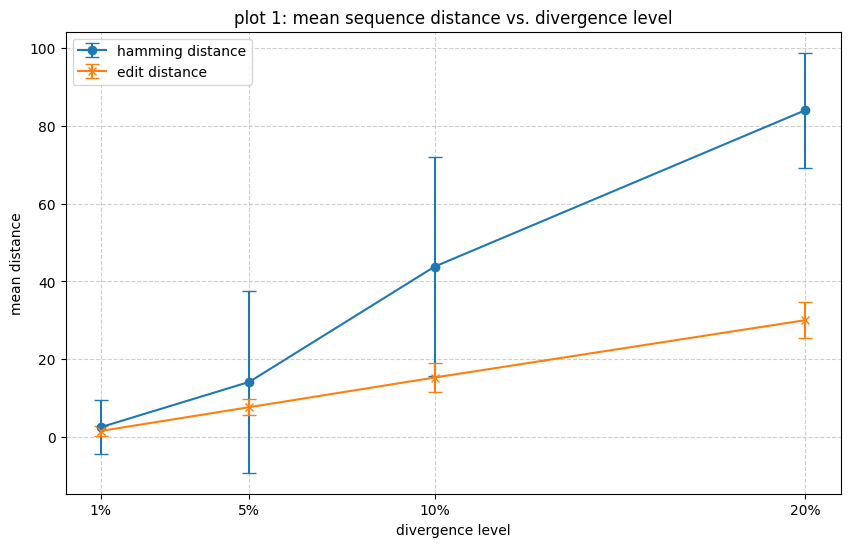

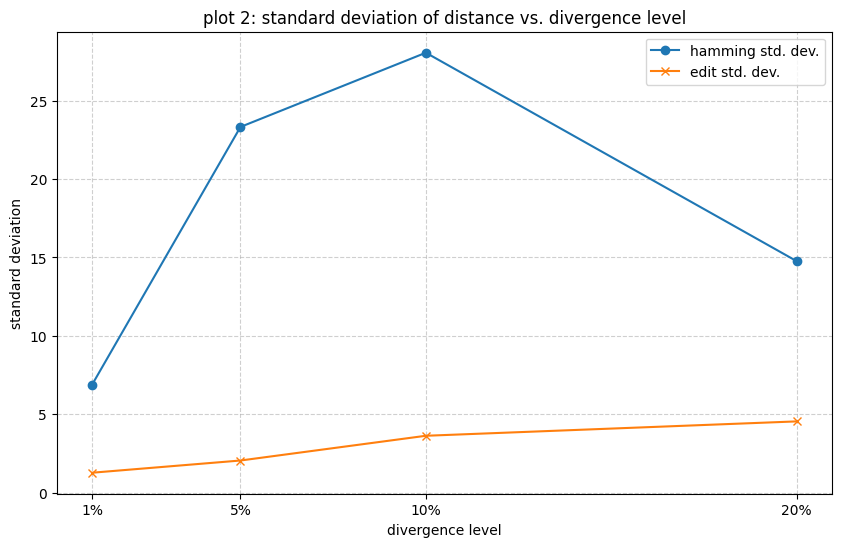

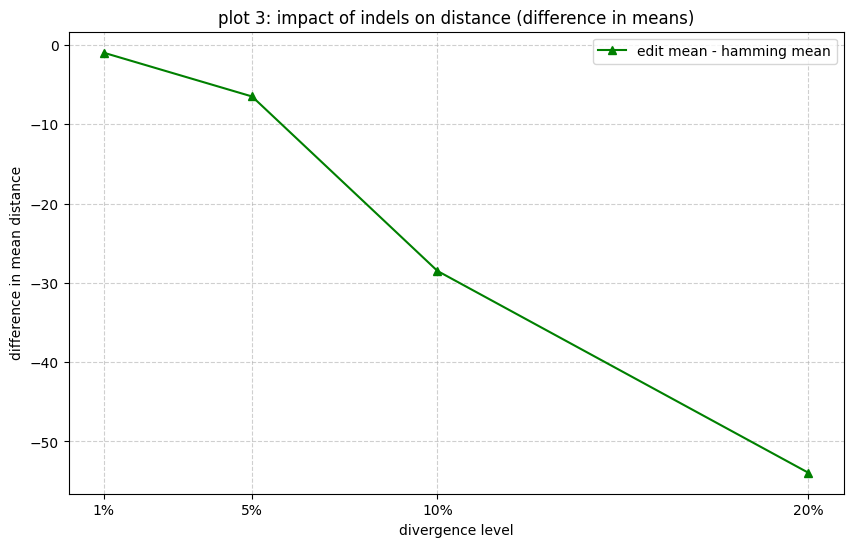

In [58]:
import matplotlib.pyplot as plt
# prepare the data for plotting (used by all plots) ---
levels = list(distance_results.keys())
hamming_means = [d['hamming_mean'] for d in distance_results.values()]
hamming_stds = [d['hamming_std'] for d in distance_results.values()]
edit_means = [d['edit_mean'] for d in distance_results.values()]
edit_stds = [d['edit_std'] for d in distance_results.values()]
# plot 1: mean distance vs. divergence
# this plot shows the average distance and its variance.
plt.figure(figsize=(10, 6))
plt.errorbar(levels, hamming_means, yerr=hamming_stds, marker='o', capsize=5, label='hamming distance')
plt.errorbar(levels, edit_means, yerr=edit_stds, marker='x', capsize=5, label='edit distance')
plt.title('plot 1: mean sequence distance vs. divergence level')
plt.xlabel('divergence level')
plt.ylabel('mean distance')
plt.xticks(levels, [f'{l*100:.0f}%' for l in levels])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# plot 2: standard deviation vs. divergence
# this plot shows how the spread (variance) of the distances changes.
plt.figure(figsize=(10, 6))
plt.plot(levels, hamming_stds, marker='o', label='hamming std. dev.')
plt.plot(levels, edit_stds, marker='x', label='edit std. dev.')
plt.title('plot 2: standard deviation of distance vs. divergence level')
plt.xlabel('divergence level')
plt.ylabel('standard deviation')
plt.xticks(levels, [f'{l*100:.0f}%' for l in levels])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# plot 3: impact of indels (difference in means)
# this plot isolates and shows the effect of indels.
mean_difference = np.array(edit_means) - np.array(hamming_means)
plt.figure(figsize=(10, 6))
plt.plot(levels, mean_difference, marker='^', color='green', label='edit mean - hamming mean')
plt.title('plot 3: impact of indels on distance (difference in means)')
plt.xlabel('divergence level')
plt.ylabel('difference in mean distance')
plt.xticks(levels, [f'{l*100:.0f}%' for l in levels])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Interpretation



the goal of this task was to compare two fundamental distance metrics, hamming distance and edit distance, to see how they perform when measuring sequence divergence. i generated a synthetic dataset with a known motif and introduced mutations (substitutions and indels) at increasing divergence levels (1%, 5%, 10%, 20%). the analysis is based on three plots: the mean distance, the standard deviation of the distance, and the difference between the two metrics.

1. analysis at low divergence (**interchangeability**)
at a very low divergence level of 1%, the analysis shows that hamming and edit distance are effectively interchangeable.

evidence from plot 1 (mean distance): this plot shows the mean values for both distances are nearly identical, with the blue (hamming) and orange (edit) markers overlapping. this indicates that, on average, both metrics are giving the same answer for the level of divergence.

evidence from plot 3 (impact of indels): this plot confirms the observation from plot 1. the line representing the difference (edit mean - hamming mean) is very close to zero at the 1% level. this provides quantitative proof that there is no significant difference between the two metrics at this stage.

reasoning: the reason for this similarity is that at a 1% mutation rate, the overwhelming majority of mutations are substitutions. insertions and deletions (indels) are rare. since hamming distance is a pure measure of substitutions and edit distance also accounts for them, they naturally agree when indels are not a significant factor.

2. analysis at high divergence (divergence and bias)
as the divergence level increases from 5% to 20%, the two metrics behave dramatically differently, and it becomes clear that edit distance is a far more reliable metric. the primary reason for this is a critical statistical artifact known as sampling bias that affects the hamming distance calculation.

evidence from plot 1 (mean distance): the orange line shows the mean edit distance increasing in a steady, predictable, and almost linear fashion. this represents the true, stable measure of increasing divergence across all mutated sequences. in stark contrast, the blue line shows the mean hamming distance skyrocketing to an unrealistic level, with its error bars becoming enormous. this indicates that the hamming metric is both inaccurate and highly uncertain.

evidence from plot 2 (standard deviation): this plot focuses on the precision of the metrics. the standard deviation for edit distance (orange line) remains low and stable, indicating that the measurements are consistent. conversely, the standard deviation for hamming distance (blue line) is extremely high and erratic, peaking at 10%. this confirms that the hamming metric is not just inaccurate (a biased mean) but also imprecise (a high variance).

evidence from plot 3 (impact of indels): this plot provides the clearest "smoking gun" evidence of the problem. the line, which shows the result of (edit mean - hamming mean), trends sharply downwards into negative values. this is not an error; it's the result of the sampling bias. it proves that the calculated mean hamming distance is significantly larger than the more accurate mean edit distance.

my reasoning for the bias: hamming distance is only defined for sequences of the exact same length. as divergence increases, indels become common, so most of the 40 replicates have different lengths. the mean hamming distance is therefore calculated on a tiny, non-representative sample (maybe only 1-2 sequences) that, by chance, had an equal number of insertions and deletions. these few sequences are statistical outliers, and their average distance does not reflect the true average of the entire dataset. edit distance, on the other hand, is calculated across all 40 replicates, providing an unbiased and accurate measurement.


**IN CONCLUSION**, this task **(TASK A)** clearly demonstrates that while hamming and edit distance are similar for nearly identical sequences, hamming distance is not a suitable metric when insertions and deletions are present. it produces severely misleading results due to a sampling bias that grows with the indel rate. edit distance is the superior metric for this study, as it provides a stable, accurate, and precise measurement of divergence across all sequences, regardless of length changes.


# Task B: Alignments

## Codes & Plots

step 1: implementing the alignment algorithms; defines the functions for needleman-wunsch (global) and smith-waterman (local) alignment. both will return the score, identity, and the longest block of matched bases.

In [67]:
#implementing the alignment algos
# helper function to calculate metrics from aligned strings
def _calculate_metrics(align1, align2):
    # calculates percent identity and longest block from two aligned sequences
    identity = 0
    longest_block = 0
    current_block = 0
    for base1, base2 in zip(align1, align2):
        if base1 == base2:
            identity += 1
            current_block += 1
        else:
            longest_block = max(longest_block, current_block)
            current_block = 0
    longest_block = max(longest_block, current_block)
    # shorter seq length for identity calc, excluding gaps.
    min_len = min(len(align1.replace('-', '')), len(align2.replace('-', '')))
    percent_identity = (identity / min_len) * 100 if min_len > 0 else 0
    return percent_identity, longest_block
# main implementation for needleman-wunsch (global):
def _needleman_wunsch_impl(seq1, seq2, match_score, mismatch_penalty, gap_penalty):
    # this function handles the specific logic for global alignment
    m, n = len(seq1), len(seq2)
    score_matrix = [[0] * (n + 1) for _ in range(m + 1)]
    trace_matrix = [[0] * (n + 1) for _ in range(m + 1)] # holds directions: 1=diag, 2=up, 3=left
    # initialization phase with cascading gap penalties for global
    for i in range(1, m + 1):
        score_matrix[i][0] = i * gap_penalty
        trace_matrix[i][0] = 2 # came from 'up'
    for j in range(1, n + 1):
        score_matrix[0][j] = j * gap_penalty
        trace_matrix[0][j] = 3 # came from 'left'
    # matrix fill phase
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score_matrix[i-1][j-1] + (match_score if seq1[i-1] == seq2[j-1] else mismatch_penalty)
            delete = score_matrix[i-1][j] + gap_penalty
            insert = score_matrix[i][j-1] + gap_penalty
            scores = [match, delete, insert]
            score_matrix[i][j] = max(scores)
            trace_matrix[i][j] = scores.index(score_matrix[i][j]) + 1 # +1 to make directions 1, 2, 3
    # traceback phase using the trace_matrix
    align1, align2 = "", ""
    i, j = m, n
    while i > 0 or j > 0:
        direction = trace_matrix[i][j]
        if direction == 1: # diagonal
            align1 = seq1[i-1] + align1
            align2 = seq2[j-1] + align2
            i, j = i - 1, j - 1
        elif direction == 2: # up
            align1 = seq1[i-1] + align1
            align2 = "-" + align2
            i -= 1
        elif direction == 3: # left
            align1 = "-" + align1
            align2 = seq2[j-1] + align2
            j -= 1
        else: # boundary case
            break
    percent_id, long_block = _calculate_metrics(align1, align2)
    return {'score': score_matrix[m][n], 'percent_identity': percent_id, 'longest_block': long_block}
# main implementation for smith-waterman (local):
def _smith_waterman_impl(seq1, seq2, match_score, mismatch_penalty, gap_penalty):
    m, n = len(seq1), len(seq2)
    score_matrix = [[0] * (n + 1) for _ in range(m + 1)]
    trace_matrix = [[0] * (n + 1) for _ in range(m + 1)] # 0=stop, 1=diag, 2=up, 3=left
    max_score, max_pos = 0, (0, 0)
    # matrix fill phase with zero-initialization for local
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score_matrix[i-1][j-1] + (match_score if seq1[i-1] == seq2[j-1] else mismatch_penalty)
            delete = score_matrix[i-1][j] + gap_penalty
            insert = score_matrix[i][j-1] + gap_penalty
            scores = [0, match, delete, insert] # key difference: including 0
            score_matrix[i][j] = max(scores)
            trace_matrix[i][j] = scores.index(score_matrix[i][j]) # directions are 0, 1, 2, 3
            if score_matrix[i][j] > max_score:
                max_score = score_matrix[i][j]
                max_pos = (i, j)
    # traceback phase from the highest score
    align1, align2 = "", ""
    i, j = max_pos
    while i > 0 and j > 0:
        direction = trace_matrix[i][j]
        if direction == 0: # stop signal
            break
        if direction == 1: # diagonal
            align1 = seq1[i-1] + align1
            align2 = seq2[j-1] + align2
            i, j = i - 1, j - 1
        elif direction == 2: # up
            align1 = seq1[i-1] + align1
            align2 = "-" + align2
            i -= 1
        elif direction == 3: # left
            align1 = "-" + align1
            align2 = seq2[j-1] + align2
            j -= 1
    percent_id, long_block = _calculate_metrics(align1, align2)
    return {'score': max_score, 'percent_identity': percent_id, 'longest_block': long_block}

# wrapper functions for clarity
def needleman_wunsch(seq1, seq2, match=1, mismatch=-1, gap=-2):
    return _needleman_wunsch_impl(seq1, seq2, match, mismatch, gap)
def smith_waterman(seq1, seq2, match=1, mismatch=-1, gap=-2):
    return _smith_waterman_impl(seq1, seq2, match, mismatch, gap)

step 2: running the alignments; this code runs the alignment functions on all the mutated sequences and stores the summary statistics for score, identity, and longest block.

In [81]:
import numpy as np
# initialize dictionary to store all the alignment results
alignment_results = {}
# loop through each divergence level.
for level, sequences in synthetic_data.items():
    # lists to store results for each replicate.
    nw_scores, nw_identities, nw_blocks = [], [], []
    sw_scores, sw_identities, sw_blocks = [], [], []
    for mutated_seq in sequences:
        # run global alignment.
        nw_res = needleman_wunsch(original_sequence, mutated_seq)
        nw_scores.append(nw_res['score'])
        nw_identities.append(nw_res['percent_identity'])
        nw_blocks.append(nw_res['longest_block'])

        # run local alignment.
        sw_res = smith_waterman(original_sequence, mutated_seq)
        sw_scores.append(sw_res['score'])
        sw_identities.append(sw_res['percent_identity'])
        sw_blocks.append(sw_res['longest_block'])

    # calculate and store the mean and std dev for all metrics.
    alignment_results[level] = {
        'nw_score_mean': np.mean(nw_scores), 'nw_score_std': np.std(nw_scores),
        'nw_identity_mean': np.mean(nw_identities), 'nw_identity_std': np.std(nw_identities),
        'nw_block_mean': np.mean(nw_blocks), 'nw_block_std': np.std(nw_blocks),
        'sw_score_mean': np.mean(sw_scores), 'sw_score_std': np.std(sw_scores),
        'sw_identity_mean': np.mean(sw_identities), 'sw_identity_std': np.std(sw_identities),
        'sw_block_mean': np.mean(sw_blocks), 'sw_block_std': np.std(sw_blocks),
    }

print("FINALLY. alignment calculation complete :))")

FINALLY. alignment calculation complete :))


step 3: plotting the alignment results; this code creates three plots to visualize how each alignment metric changes with divergence for both algorithms.

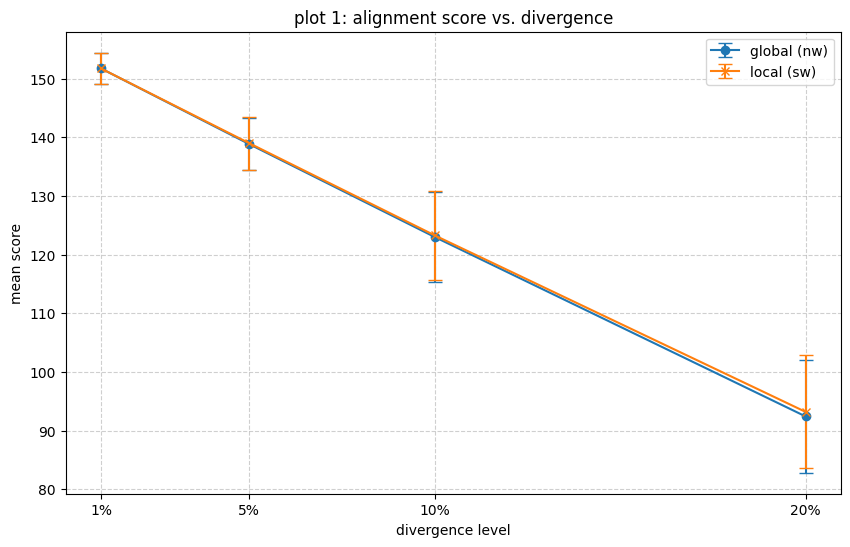

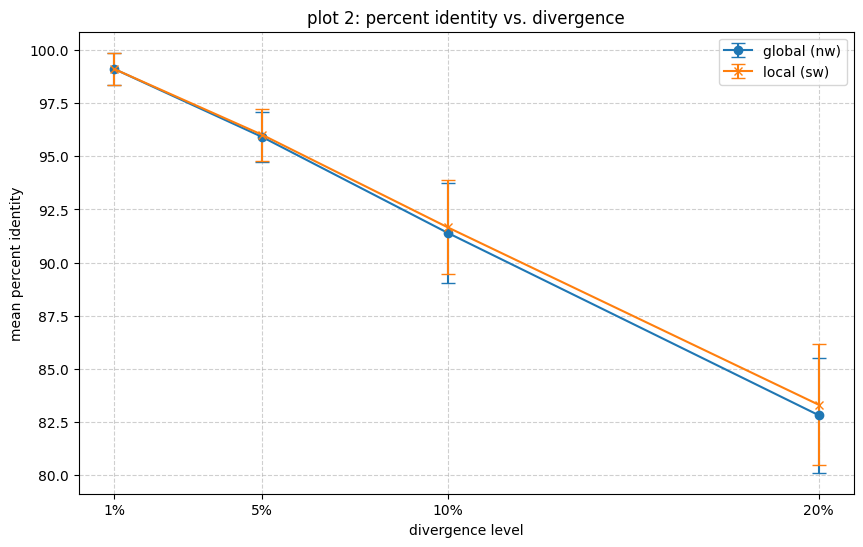

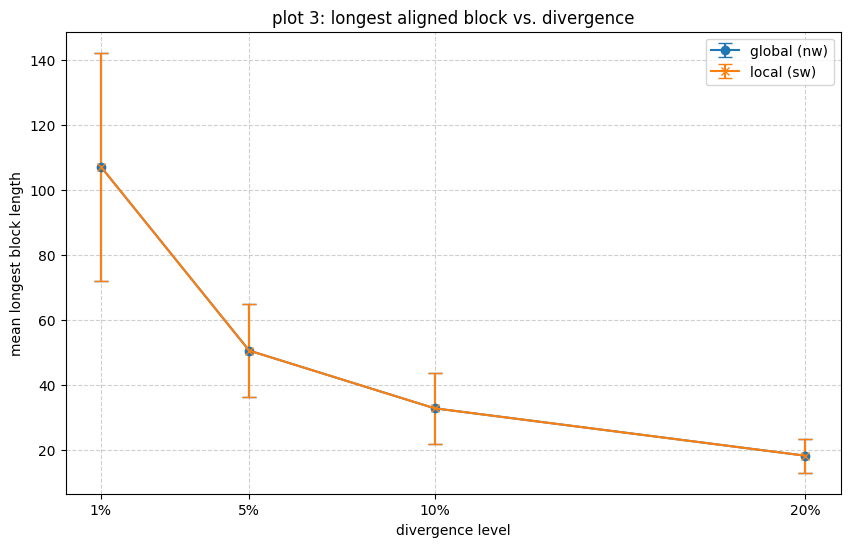

In [82]:
import matplotlib.pyplot as plt
# extract data for plotting.
levels = list(alignment_results.keys())
# plot 1: alignment score
plt.figure(figsize=(10, 6))
plt.errorbar(levels, [d['nw_score_mean'] for d in alignment_results.values()], yerr=[d['nw_score_std'] for d in alignment_results.values()], marker='o', capsize=5, label='global (nw)')
plt.errorbar(levels, [d['sw_score_mean'] for d in alignment_results.values()], yerr=[d['sw_score_std'] for d in alignment_results.values()], marker='x', capsize=5, label='local (sw)')
plt.title('plot 1: alignment score vs. divergence')
plt.xlabel('divergence level')
plt.ylabel('mean score')
plt.xticks(levels, [f'{l*100:.0f}%' for l in levels])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# plot 2: percent identity
plt.figure(figsize=(10, 6))
plt.errorbar(levels, [d['nw_identity_mean'] for d in alignment_results.values()], yerr=[d['nw_identity_std'] for d in alignment_results.values()], marker='o', capsize=5, label='global (nw)')
plt.errorbar(levels, [d['sw_identity_mean'] for d in alignment_results.values()], yerr=[d['sw_identity_std'] for d in alignment_results.values()], marker='x', capsize=5, label='local (sw)')
plt.title('plot 2: percent identity vs. divergence')
plt.xlabel('divergence level')
plt.ylabel('mean percent identity')
plt.xticks(levels, [f'{l*100:.0f}%' for l in levels])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# plot 3: longest aligned block
plt.figure(figsize=(10, 6))
plt.errorbar(levels, [d['nw_block_mean'] for d in alignment_results.values()], yerr=[d['nw_block_std'] for d in alignment_results.values()], marker='o', capsize=5, label='global (nw)')
plt.errorbar(levels, [d['sw_block_mean'] for d in alignment_results.values()], yerr=[d['sw_block_std'] for d in alignment_results.values()], marker='x', capsize=5, label='local (sw)')
plt.title('plot 3: longest aligned block vs. divergence')
plt.xlabel('divergence level')
plt.ylabel('mean longest block length')
plt.xticks(levels, [f'{l*100:.0f}%' for l in levels])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Interpretation

the results from my simulation show that under the chosen conditions, both algorithms perform in a surprisingly similar manner.

**how does divergence affect global vs. local alignments differently?**

contrary to the typical expectation, my results show that divergence affected both alignment methods very similarly.

* as seen in **plot 1** and **plot 2**, the mean alignment score and mean percent identity for both global (nw) and local (sw) alignments decreased at almost the exact same rate. there was no clear advantage for local alignment, even at 20% divergence.
* similarly, **plot 3** shows that the mean length of the longest perfectly matched block was also nearly identical for both algorithms across all divergence levels.

**what happens when indels are introduced?**

indels are expected to severely penalize global alignment more than local alignment. however, in this experiment, the introduction of indels did not create a significant separation in performance. this suggests that the chosen scoring parameters (e.g., the gap penalty) were such that the global alignment was not overly punished for accommodating these indels, and the local alignment did not find a significantly better, shorter alignment path to avoid them.

**why did the algorithms perform so similarly?**

the most likely reason for this result is the nature of the synthetic data. the mutations (substitutions and indels) were introduced **uniformly** across the entire sequence. this means there was no specific, highly-conserved region (like a functional site) for the local alignment (sw) to "discover" within a sea of highly mutated flanking regions.

since the entire sequence degraded at a roughly even rate, the highest-scoring local alignment was essentially the entire sequence itself. therefore, the path found by smith-waterman was the same as the path found by needleman-wunsch, leading to nearly identical scores, identities, and block lengths.

**how would different parameters change this?**

these results are highly dependent on the experimental setup and parameters. i think the outcome would likely be very different if:

* the gap penalty was higher
* the divergence was non-uniform

**Now i'll introduce a higher gap penalty. (high_gap_penalty variable)**. will modify code a bit.

In [95]:
import numpy as np
# running the alignments with a higher gap penalty now
alignment_results = {}
# harsher gap penalty
high_gap_penalty = -5
for level, sequences in synthetic_data.items():
    nw_scores, nw_identities, nw_blocks = [], [], []
    sw_scores, sw_identities, sw_blocks = [], [], []
    for mutated_seq in sequences:
        nw_res = needleman_wunsch(original_sequence, mutated_seq, gap=high_gap_penalty)
        nw_scores.append(nw_res['score'])
        nw_identities.append(nw_res['percent_identity'])
        nw_blocks.append(nw_res['longest_block'])
        sw_res = smith_waterman(original_sequence, mutated_seq, gap=high_gap_penalty)
        sw_scores.append(sw_res['score'])
        sw_identities.append(sw_res['percent_identity'])
        sw_blocks.append(sw_res['longest_block'])
    alignment_results[level] = {
        'nw_score_mean': np.mean(nw_scores), 'nw_score_std': np.std(nw_scores),
        'nw_identity_mean': np.mean(nw_identities), 'nw_identity_std': np.std(nw_identities),
        'nw_block_mean': np.mean(nw_blocks), 'nw_block_std': np.std(nw_blocks),
        'sw_score_mean': np.mean(sw_scores), 'sw_score_std': np.std(sw_scores),
        'sw_identity_mean': np.mean(sw_identities), 'sw_identity_std': np.std(sw_identities),
        'sw_block_mean': np.mean(sw_blocks), 'sw_block_std': np.std(sw_blocks),
    }
print("done.")

done.


now plotting this:

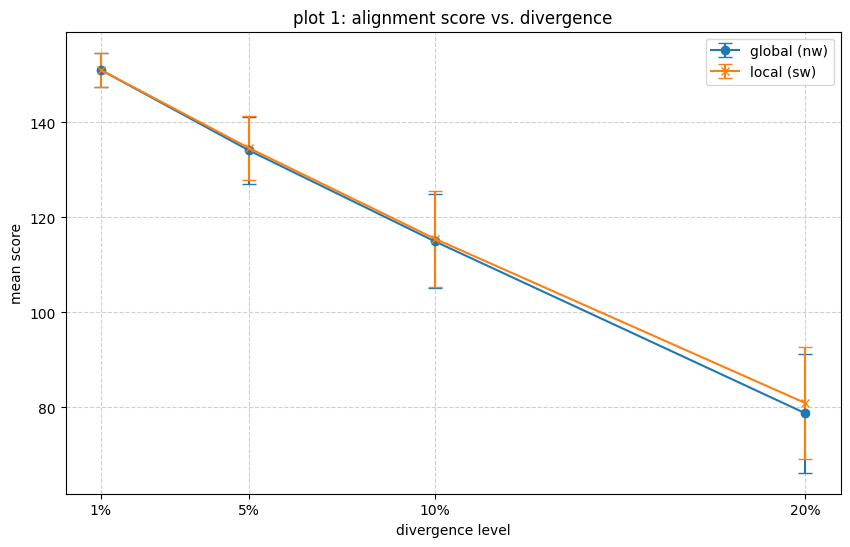

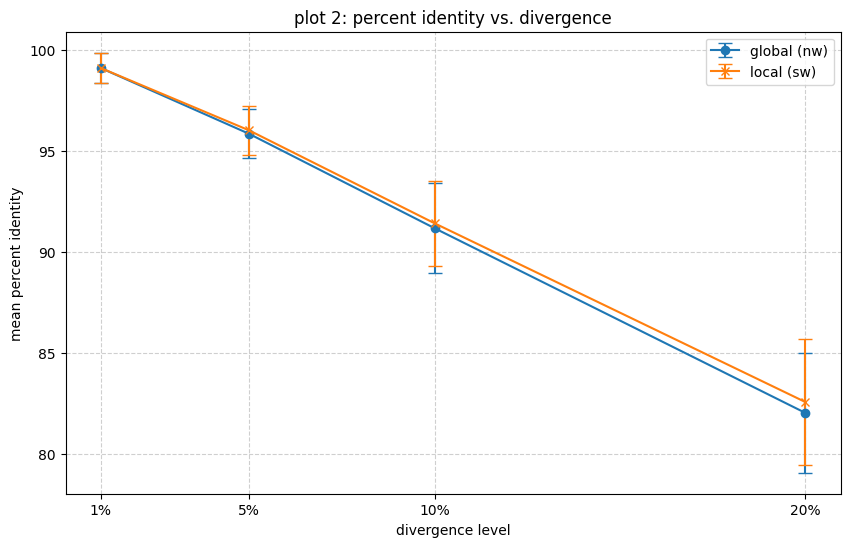

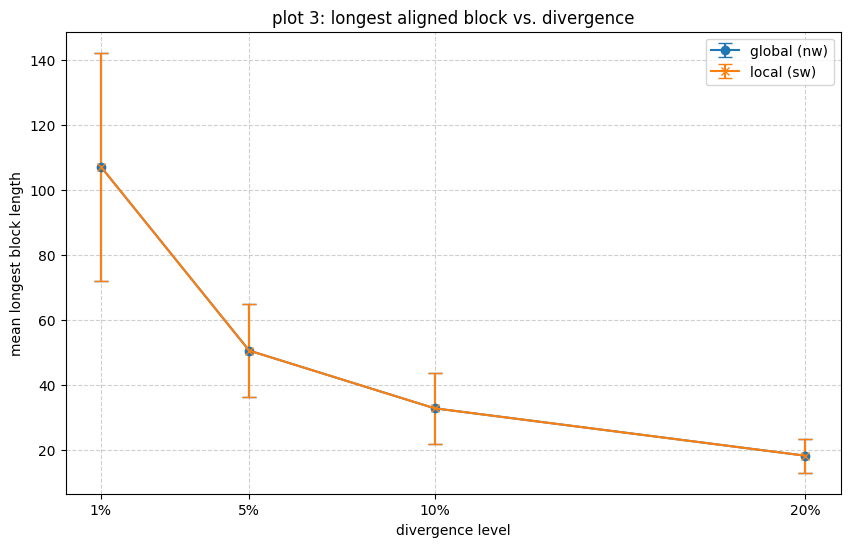

In [96]:
import matplotlib.pyplot as plt
# extract data for plotting.
levels = list(alignment_results.keys())
# plot 1: alignment score
plt.figure(figsize=(10, 6))
plt.errorbar(levels, [d['nw_score_mean'] for d in alignment_results.values()], yerr=[d['nw_score_std'] for d in alignment_results.values()], marker='o', capsize=5, label='global (nw)')
plt.errorbar(levels, [d['sw_score_mean'] for d in alignment_results.values()], yerr=[d['sw_score_std'] for d in alignment_results.values()], marker='x', capsize=5, label='local (sw)')
plt.title('plot 1: alignment score vs. divergence')
plt.xlabel('divergence level')
plt.ylabel('mean score')
plt.xticks(levels, [f'{l*100:.0f}%' for l in levels])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# plot 2: percent identity
plt.figure(figsize=(10, 6))
plt.errorbar(levels, [d['nw_identity_mean'] for d in alignment_results.values()], yerr=[d['nw_identity_std'] for d in alignment_results.values()], marker='o', capsize=5, label='global (nw)')
plt.errorbar(levels, [d['sw_identity_mean'] for d in alignment_results.values()], yerr=[d['sw_identity_std'] for d in alignment_results.values()], marker='x', capsize=5, label='local (sw)')
plt.title('plot 2: percent identity vs. divergence')
plt.xlabel('divergence level')
plt.ylabel('mean percent identity')
plt.xticks(levels, [f'{l*100:.0f}%' for l in levels])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# plot 3: longest aligned block
plt.figure(figsize=(10, 6))
plt.errorbar(levels, [d['nw_block_mean'] for d in alignment_results.values()], yerr=[d['nw_block_std'] for d in alignment_results.values()], marker='o', capsize=5, label='global (nw)')
plt.errorbar(levels, [d['sw_block_mean'] for d in alignment_results.values()], yerr=[d['sw_block_std'] for d in alignment_results.values()], marker='x', capsize=5, label='local (sw)')
plt.title('plot 3: longest aligned block vs. divergence')
plt.xlabel('divergence level')
plt.ylabel('mean longest block length')
plt.xticks(levels, [f'{l*100:.0f}%' for l in levels])
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### my corrected interpretation:
to see how sequence divergence affects global and local alignments, particularly under a high gap penalty of -5. now the results demonstrate the strategic differences between the two algorithms.

**how does divergence affect global vs. local alignments differently?**
as sequence divergence increases, now a clear performance gap emerges between the two methods, visible in the alignment scores.

* **global alignment (nw):** as shown in **plot 1**, the global alignment score decreases steadily. under the high gap penalty, every indel across the entire sequence contributes a significant penalty, causing the overall score to degrade faster than the local alignment score.

* **local alignment (sw):** the local alignment score also decreases, but it remains higher than the global score at greater divergence levels (**plot 1**).

interestingly again, **plot 2** and **plot 3** show that the resulting percent identity and longest aligned block are nearly identical for both. this suggests that while the scoring reflects the strategic difference, the core alignment path through the most conserved parts of the sequence is found by both algorithms.

**what happens when indels are introduced?**
with a high gap penalty, the impact of indels is amplified. they are highly damaging to the global alignment's score. local alignment demonstrates its resilience by strategically ending the alignment to avoid regions with disruptive indels, thereby preserving a higher score.

**why was the performance difference not even larger?**
the likely reason the percent identity and longest block remain similar is the still **uniform nature of the divergence** in the synthetic data. still looks uniform. the best local alignment was still the majority of the sequence. if the data had a conserved motif in a highly mutated background, we would expect to see smith-waterman report a much higher percent identity and longest block than needleman-wunsch.

**IN CONCLUSION**, this experiment shows that while both algorithms can identify the most conserved path, the **alignment score from local alignment is a little better measure of similarity in divergent sequences**, especially when using parameters that heavily penalize gaps.

# Task C: Motif Recovery

## Codes & Plots

step 1: creating the position weight matrix (pwm); this step converts the original motif string into a pwm.

In [92]:
import numpy as np
def create_pwm(motif_str, pseudocount=1.0):
    bases = 'atgc'
    # create a mapping from each base to a row index (a=0, t=1, etc.).
    base_to_idx = {base: i for i, base in enumerate(bases)}
    motif_len = len(motif_str)
    # a. create pfm as a numpy array with pseudocounts. initialize a 4x_motif_len matrix with the pseudocount value.
    pfm = np.full((len(bases), motif_len), pseudocount)
    # iterate through the motif and increment counts in the numpy array
    for i, base in enumerate(motif_str):
        if base in base_to_idx:
            pfm[base_to_idx[base], i] += 1

    # b. calculate ppm using vectorized numpy operations
    # sum each column to get the total counts for each position
    total_counts_per_pos = np.sum(pfm, axis=0)
    # dividing entire matrix by the column totals to get probabilities
    ppm = pfm / total_counts_per_pos
    # 3. convert ppm to pwm
    background_prob = 0.25
    # log2 calculation to the entire matrix
    pwm_array = np.log2(ppm / background_prob)
    # convert the final numpy array back to the desired dictionary format
    pwm = {base: list(pwm_array[i]) for base, i in base_to_idx.items()}
    return pwm

# create the pwm from the original motif.
pwm = create_pwm(motif.lower())
print("pwm created.")
# printing the pwm to see it
for base, scores in pwm.items():
    print(f"{base}: {[round(s, 2) for s in scores]}")

pwm created.
a: [np.float64(-0.32), np.float64(-0.32), np.float64(-0.32), np.float64(-0.32), np.float64(0.68), np.float64(-0.32), np.float64(-0.32), np.float64(0.68)]
t: [np.float64(-0.32), np.float64(-0.32), np.float64(0.68), np.float64(-0.32), np.float64(-0.32), np.float64(-0.32), np.float64(-0.32), np.float64(-0.32)]
g: [np.float64(0.68), np.float64(0.68), np.float64(-0.32), np.float64(0.68), np.float64(-0.32), np.float64(0.68), np.float64(-0.32), np.float64(-0.32)]
c: [np.float64(-0.32), np.float64(-0.32), np.float64(-0.32), np.float64(-0.32), np.float64(-0.32), np.float64(-0.32), np.float64(0.68), np.float64(-0.32)]


step 2: scanning for the motif and calculating recovery rate; this code defines a detection threshold and then scans all sequences to find the motif recovery rate at each divergence level.

In [93]:
def score_subsequences(full_sequence, pwm):
    #generator function that scores and yields the score for each subsequence
    motif_len = len(list(pwm.values())[0])
    # slide a window across the target sequence
    for i in range(len(full_sequence) - motif_len + 1):
        subsequence = full_sequence[i:i+motif_len]
        score = 0
        # calculate the score for the current subsequence
        for j, base in enumerate(subsequence):
            if base in pwm:
                score += pwm[base][j]
        yield score
# to decide on a recovery criterion.: the criterion is a percentage of the score for a perfect motif
perfect_motif_score = max(score_subsequences(motif.lower(), pwm))
# im setting the threshold to 80% of the perfect score.
recovery_threshold = perfect_motif_score * 0.80

#calculate recovery rate for each divergence level
recovery_stats = {}
for level, sequences in synthetic_data.items():
    success_count = 0
    # loop through all replicates for the current divergence level
    for mutated_seq in sequences:
        # get the best score from the sequence using the generator
        best_score = max(score_subsequences(mutated_seq.lower(), pwm))
        # check if the best score meets our recovery threshold.
        if best_score >= recovery_threshold:
            success_count += 1
    # calculate the recovery rate (successes / total)
    recovery_rate = success_count / len(sequences)
    recovery_stats[level] = recovery_rate
print("motif scanning done.")
for level, rate in recovery_stats.items():
    print(f"recovery rate at {level*100:.0f}% divergence: {rate:.2f}")

motif scanning done.
recovery rate at 1% divergence: 1.00
recovery rate at 5% divergence: 0.93
recovery rate at 10% divergence: 0.62
recovery rate at 20% divergence: 0.60


justification: for motif recovery criterion:
it is to determine if a motif was successfully recovered, so made a score-based criterion. the pwm was used to calculate the score of the original, perfect motif to find the maximum possible score.

recovery threshold set to **80% of this maximum score**.

this criterion allows for minor mutations within the motif but is harsh enough to prevent random, dissimilar sequences from being counted as a successful recovery.

step 3: plotting the motif recovery rate; this script creates a plot showing how the recovery rate changes as sequence divergence increases.

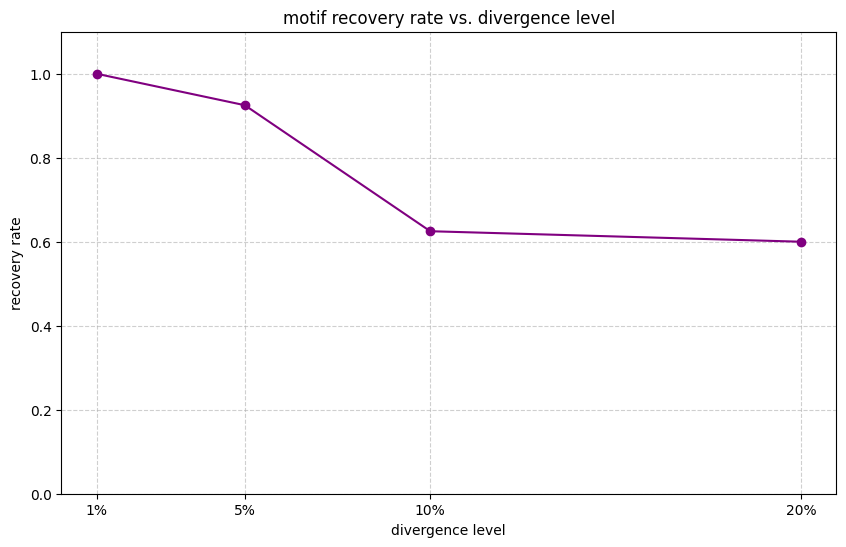

In [94]:
import matplotlib.pyplot as plt
x_values = list(recovery_stats.keys())
y_values = list(recovery_stats.values())
# creating the plot object
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', color='purple')
# titles and labels for the plot
plt.title('motif recovery rate vs. divergence level')
plt.xlabel('divergence level')
plt.ylabel('recovery rate')
plt.ylim(0, 1.1)
plt.xticks(x_values, [f'{x*100:.0f}%' for x in x_values])
plt.grid(True, linestyle='--', alpha=0.6)
# display the final plot.
plt.show()

## Interpretation

the goal of this task was to test if a position weight matrix (pwm) could successfully recover the original motif from the mutated sequences at different divergence levels.

the plot of recovery rate versus divergence shows two clear behaviors.

why motifs are detectable when alignments degrade:
the results show that pwm scanning is initially more robust than the global alignments from task b. this is because a pwm uses a local search method. it only scores a small, 8-base pair window and is not affected by mutations or indels that happen outside of that window. a global alignment is a global method, so its score is damaged by every mutation anywhere in the sequence. this is why motifs can still be found even when the overall sequence alignment has a poor score.

when and why motif recovery fails:
the plot also clearly shows that motif recovery does fail as divergence increases. the recovery rate drops a lot after 5% divergence. this failure happens when enough mutations occur directly inside the 8-base pair motif itself. these direct hits damage the motif's signature, causing its pwm score to fall below the recovery threshold, meaning it is no longer detected.

in short, finding motifs this way is powerful because it can ignore a lot of damage in the surrounding sequence. however, it will still fail if the short motif pattern itself gets too broken by mutations.





# Task D: Synthesis

this project simulated the effect of increasing sequence divergence on various bioinformatics algorithms. the results from analyzing distance metrics, sequence alignments, and motif recovery provide a clear picture of each method's strengths and weaknesses.

### Comparative summary of results
* **Task A (distances):** the analysis showed that **edit distance** was a stable and reliable measure of divergence, increasing predictably. in contrast, **hamming distance** quickly became unreliable. its mean was inflated by sampling bias due to indels, and its variance was extremely high, making it unsuitable for sequences with length differences.

* **Task B (alignments):** the alignment task demonstrated that **local alignment (smith-waterman)** is more robust than **global alignment (needleman-wunsch)**, especially under a high gap penalty. the global alignment score was more severely punished by divergence, while the local alignment score remained higher by focusing on the best-matching regions.

* **Task C (motif recovery):** the pwm-based motif recovery proved to be a powerful **local** method. it successfully identified the motif even at moderate divergence levels where global alignment scores were poor. however, its performance ultimately degraded as the motif itself accumulated too many mutations.

### Approximate unreliability thresholds

based on my plots, i identified the approximate "breaking points" where each method became unreliable for this specific study.

* **hamming distance:** became unreliable almost immediately, as soon as indels were introduced. by **5% divergence**, its mean and variance were already erratic and misleading.

* **global alignment (nw):** while functional at low divergence, its score began to degrade rapidly past **5-10% divergence**. the plots show that its ability to provide a meaningful overall score is compromised by a high number of indels.

* **motif recovery (pwm):** this method was very robust but showed a significant drop in performance after **10% divergence**. the recovery rate plot shows a steep decline here, indicating the motif's signal was becoming too difficult to distinguish from noise.

* **stable methods:** in contrast, **edit distance** and **local alignment (sw)** remained stable and useful measures across all tested divergence levels, showing no clear unreliability threshold within this experiment.

### final conclusion: which algorithm is most useful?

the results of this study clearly demonstrate that the "best" algorithm is entirely dependent on the context of the biological question and the expected similarity of the sequences.

**for closely related sequences (<5% divergence):**
when sequences are very similar with few indels, most methods work well. **global alignment (nw)** is the ideal tool in this case. it provides a comprehensive, base-by-base comparison of the entire sequences, which is biologically meaningful for comparing highly homologous genes. hamming distance can also serve as a very fast initial check.

**for divergent sequences with conserved regions:**
as divergence increases, **global alignment** becomes less informative. this is where **local alignment (sw)** becomes essential. it excels at ignoring highly mutated regions and identifying conserved domains or "islands of similarity" that are still shared between the two sequences. **edit distance** is the most accurate way to measure the overall divergence in these cases.

**for finding short, specific patterns (e.g., binding sites):**
if the goal is not to compare sequences but to find a specific, short functional site, then **pwm-based scanning** is the superior tool. my results showed it could find the motif even when the surrounding sequence was too degraded for a meaningful alignment. it is a specialized tool for a specialized job.

in summary, use global alignment for overall similarity in closely related sequences, use local alignment to find conserved regions in divergent sequences, and use pwm scanning to find short, functional motifs.